## 1. **Motivation**.
- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?

How quick are first responders in San Francisco to get on scene? Using the *Fire Department Calls for Service* dataset from the San Francisco open data, found [here](https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3), the aim of our analysis was to dive deep into the time it takes to get on scene in case of emergencies in San Franciso. We have all worked before with city data from San Francisco and thus wanted to use our prior knowledge about the city to investigate fire department emergency calls. After this investigation we want to find a story about how on scene time has changed over time and if COVID-19 has had an influence on it. The story also revolves around how quick first responders are on scene in different naighborhoods around San Francisco. We hope that a user viewing our story gains insight into response time of first responders in San Francisco and the story of its change over time.

In [1]:
""" Importing packages """
import pandas as pd
import folium
import plotly.express as px
import matplotlib.pyplot as plt

# Bokeh
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import show, output_notebook

# Seaborn
import seaborn as sns

# Local
from utils.make_data import get_data, clean_data, get_neighborhoods
from utils.const import FILTER_CALL_TYPES
from utils.help_functions import get_viridis_pallette, format_string
from utils.plot_functions import (
    make_bokeh_line_plot,
    make_map,
    make_bokeh_tabs,
    make_cal_plot,
    make_boxplot
)

In [2]:
""" Importing data """
# The raw data
dat_raw = get_data()
# The cleaned data
dat = clean_data(dat_raw)
# The geojason file with the neighborhoods of San Francisco
neighborhoods = get_neighborhoods()

## 2. **Basic stats**. 
Let's understand the dataset better
- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

The following section contains our initial analys of the dataset and preprocessing. note that some of the code in this notebook contains function calls to functions we have created ourselves and all such code can be found in our [github repo](https://github.com/signyk/socialdataanalysis).  The raw data contains about 6.2 million rows so for our preprocessing, which takes place in the clean_data() function above, we  drop a lot of rows. We start by deciding how many years we want to look at. As we are interested in the response time over the years and especially the influence of COVID-19 we deceded to only work with the years 2017-2022 since we get some years before COVID-19 and after COVID-19. next, we drop all rows which don't end in a first responder arriving on scene. Our main analysis is about the time it takes to get on scene so we are not interested in, for example, how long it takes a second ambulence to get on scene so we drop all rows not containing the first responder on scene. We also create a new variable *on scene time* which is the time from when 911 first gets a call until the first responders arrive on scene. After creating the *on scene time* we discovered many human errors in the timestamps. Sometimes if the call extends past midnight the wrong date is entered and sometimes there is a clear mixup between am and pm. Thus we decided to take out all rows with *on scene time* more than 12 hours so we capture all these errors. We might be missing some influential rows but deceded that as we have so many rows of data and most response times are well under an hour that this was a reasonable decision. After this preprocessing and dropping columns we are not interested in, the dataset contains the following columns and number of rows:

In [3]:
print("Columns of our cleaned dataset: ")
print(dat.columns)
print("Number of rows in our cleaned dataset:", len(dat))

Columns of our cleaned dataset: 
Index(['call_number', 'unit_id', 'incident_number', 'call_type', 'call_date',
       'watch_date', 'received_dttm', 'entry_dttm', 'dispatch_dttm',
       'response_dttm', 'on_scene_dttm', 'transport_dttm', 'hospital_dttm',
       'call_final_disposition', 'available_dttm', 'address', 'battalion',
       'station_area', 'Priority', 'als_unit', 'call_type_group',
       'number_of_alarms', 'unit_type', 'unit_sequence', 'neighborhood',
       'row_id', 'latitude', 'longitude', 'hour', 'period_of_day',
       'on_scene_time', 'transport_time'],
      dtype='object')
Number of rows in our cleaned dataset: 804944


**Lýsa dálkunum**

Next, we show a few plots from our initial analysis:

### Response time by call type

In [4]:
print("Types of calls, sorted by count: ")
call_types_sorted = dat["call_type"].value_counts()
call_types_sorted

Types of calls, sorted by count: 


call_type
Medical Incident                                769124
Traffic Collision                                27696
Other                                             3435
Citizen Assist / Service Call                     1967
Structure Fire                                    1323
Water Rescue                                       381
Alarms                                             335
Industrial Accidents                               127
Vehicle Fire                                       107
Outside Fire                                        85
Elevator / Escalator Rescue                         79
Gas Leak (Natural and LP Gases)                     66
Confined Space / Structure Collapse                 34
Extrication / Entrapped (Machinery, Vehicle)        34
Odor (Strange / Unknown)                            27
High Angle Rescue                                   26
Assist Police                                       26
Fuel Spill                                          23


The list above shows the number of calls received per call type. Notably, *medical incident* is by far the most common. 
To further analyse the types of calls we can look to the plot below. 
From the plot we see that the on-scene time for medical incidents has increased over the last few years (while the other common types don't) so that call type is of interest to us. We thus decided that working forward we are mostly interested in the medical incident call type.

In [5]:
# Bokeh plot of the average response time by call type over the years and months"""
plot_dat = dat.copy()
plot_dat["Year_month"] = plot_dat["received_dttm"].dt.to_period("M").astype(str)
year_months = [
    "-".join([str(i), str(j).zfill(2)]) for i in range(2017, 2022) for j in range(1, 13)
]

p = make_bokeh_line_plot(
    plot_dat,
    "bokeh_call_types.html",
    ["Medical Incident", "Structure Fire", "Traffic Collision"],
    "call_type",
    "Year_month",
    "on_scene_time",
    year_months,
    notebook=True,
)

# Hide labels on x axis
p.xaxis.major_label_text_font_size = "0pt"

show(p)

Loading BokehJS ...

**Plot description:** This plot shows the mean *on scene time* for each month in the years 2017-2022 for a few interesting call types.  

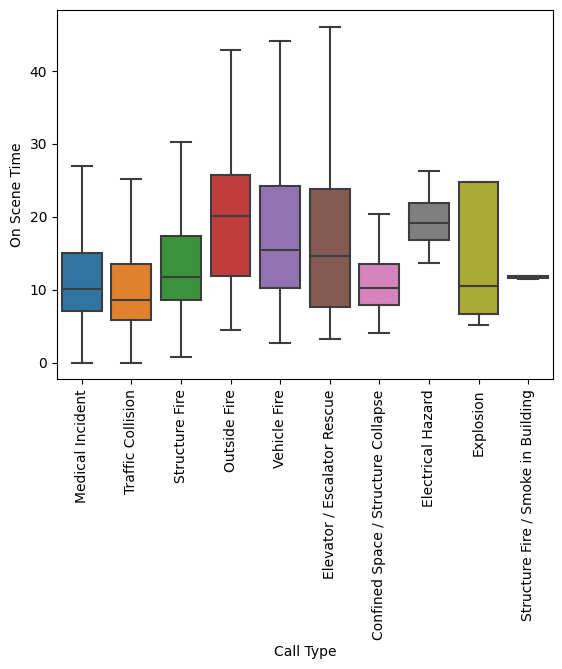

In [6]:
# Boxplots of the average response time by call type
b = make_boxplot(dat, FILTER_CALL_TYPES, x_var="call_type", y_var="on_scene_time")
plt.show(b)

**Plot description:** Here we see a boxplot of *on scene time* for different call types.

### Response time by neighborhood

In [7]:
# Bokeh plot with tabs showing the average response and transport time by neighborhood over the years"""
plot_dat = dat.copy()
plot_dat["Year"] = plot_dat["received_dttm"].dt.year

p1 = make_bokeh_line_plot(
    plot_dat,
    "bokeh_neighborhoods.html",
    FILTER_CALL_TYPES,
    "neighborhood",
    "Year",
    "on_scene_time",
    notebook=True,
)

p2 = make_bokeh_line_plot(
    plot_dat,
    "bokeh_neighborhoods.html",
    FILTER_CALL_TYPES,
    "neighborhood",
    "Year",
    "transport_time",
    notebook=True,
)

tabs_plot = make_bokeh_tabs([p1, p2])
show(tabs_plot)

Loading BokehJS ...

Loading BokehJS ...

**Plot description:** Here we see *on scene time* again over the years but this time by neighbourhood. We have also added a new variable *transport time* which can be seen in the other tab. *Transport time* refers to the time it takes to transport patients from scene to a hospital. 

From the plot for *on scene time* we again see that the response time has increased over recent years for most neighbourhoods. We do not see the same clear trend for *transport time.* 

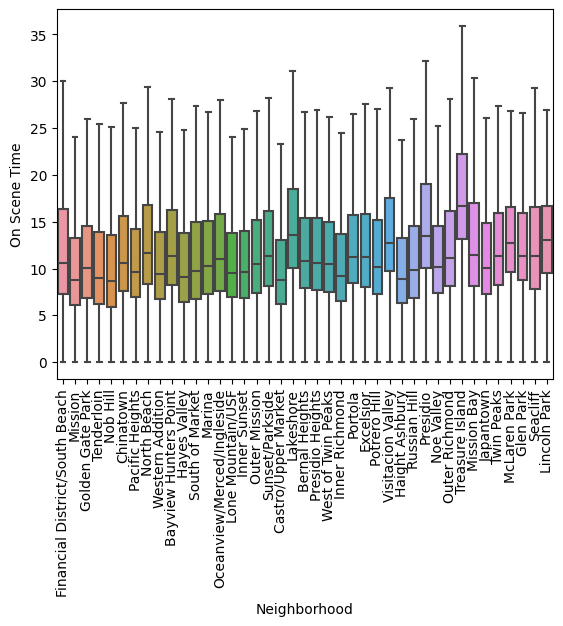

In [8]:
# Boxplots of the average response time by neighborhood
b = make_boxplot(dat, FILTER_CALL_TYPES, x_var="neighborhood", y_var="on_scene_time")
plt.show(b)

**Plot description:** Here we see a boxplot of *On scene time* for each neighborhood.

### Only medical incidents

Like we discussed before the most interesting call type seems to be medical incidents so here below we look at some plots only related to medical incidents.

In [9]:
# Bokeh plot with tabs showing the average response and transport time by neighborhood over the years for medical incidents
plot_dat = dat.copy()
plot_dat["Year"] = plot_dat["received_dttm"].dt.year  # .astype(str)

p1 = make_bokeh_line_plot(
    plot_dat,
    "bokeh_neighborhoods.html",
    ["Medical Incident"],
    "neighborhood",
    "Year",
    "on_scene_time",
)

p2 = make_bokeh_line_plot(
    plot_dat,
    "bokeh_neighborhoods.html",
    ["Medical Incident"],
    "neighborhood",
    "Year",
    "transport_time",
)

tabs_plot = make_bokeh_tabs([p1, p2])
show(tabs_plot)

**Plot description:** Now we look at *On scene time* and *Transport time* again for the different neighbourhoods but now only for the medical incidents call type.

For *On scene time* we again see the increase in recent years but we don't see the same clear increase in *Transport time*.

In [10]:
# Bokeh plot showing the average response time by year, split into intake, queue and travel time
output_notebook()
split_time_data = dat.copy()
split_time_data = split_time_data[split_time_data["call_type"].isin(["Medical Incident"])]

## Create the split times
split_time_data["intake_time"] = (
    split_time_data["entry_dttm"] - split_time_data["received_dttm"]
).dt.total_seconds() / 60
split_time_data["queue_time"] = (
    split_time_data["dispatch_dttm"] - split_time_data["entry_dttm"]
).dt.total_seconds() / 60
split_time_data["travel_time"] = (
    split_time_data["on_scene_dttm"] - split_time_data["dispatch_dttm"]
).dt.total_seconds() / 60

# Create the year variable
split_time_data["Year"] = split_time_data["received_dttm"].dt.year.astype(str)

# Transform the data to long format
long = split_time_data.melt(
    id_vars="Year",
    value_vars=["intake_time", "queue_time", "travel_time"],
    var_name="Time",
    value_name="minutes",
)

# Calculate the mean time per year for all split times
res = long.groupby(["Time", "Year"])["minutes"].mean().reset_index(name="mean")

# Pivot the data to wide format
processed_dat = res.pivot(index="Year", columns="Time", values="mean").reset_index()

# Create the source for the plot
descripts = [d for d in list(long["Time"].unique()) if not pd.isna(d)]
src = ColumnDataSource(processed_dat)
x_range = processed_dat["Year"].unique().tolist()
viridis = get_viridis_pallette(len(descripts))

# Stacked bar chart
p = figure(
    x_range=x_range,
    height=500,
    width=800,
    title="Average on-scene time per year",
    toolbar_location=None,
    tools="hover",
    tooltips=[
        ("Type", "$name"),
        ("Year", "@Year"),
        ("Time", "@$name"),
    ],
)

p.vbar_stack(
    descripts,
    x="Year",
    width=0.9,
    source=src,
    color=viridis,
    legend_label=[format_string(d) for d in descripts],
)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "vertical"
p.add_layout(p.legend[0], "left")

show(p)

Loading BokehJS ...

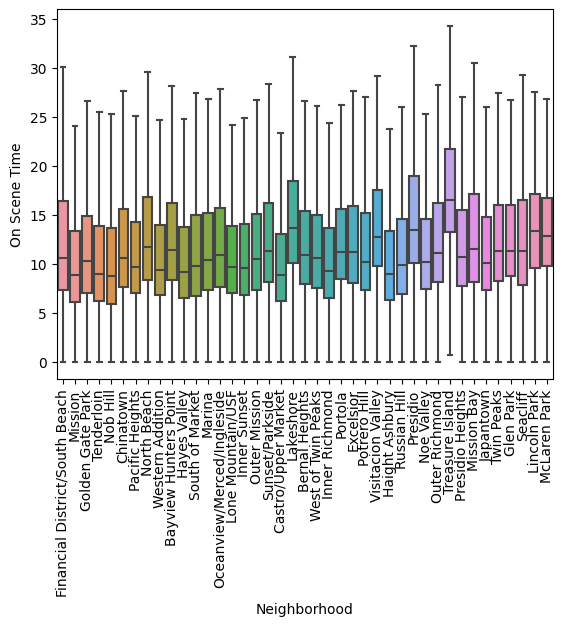

In [11]:
# Boxplots of the average response time by neighborhood, 
b = make_boxplot(dat, ["Medical Incident"], x_var="neighborhood", y_var="on_scene_time")
plt.show(b)

/var/folders/2v/76qdb2rd0xzbgt6wjw2vgg2h0000gn/T/ipykernel_35984/4241192924.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


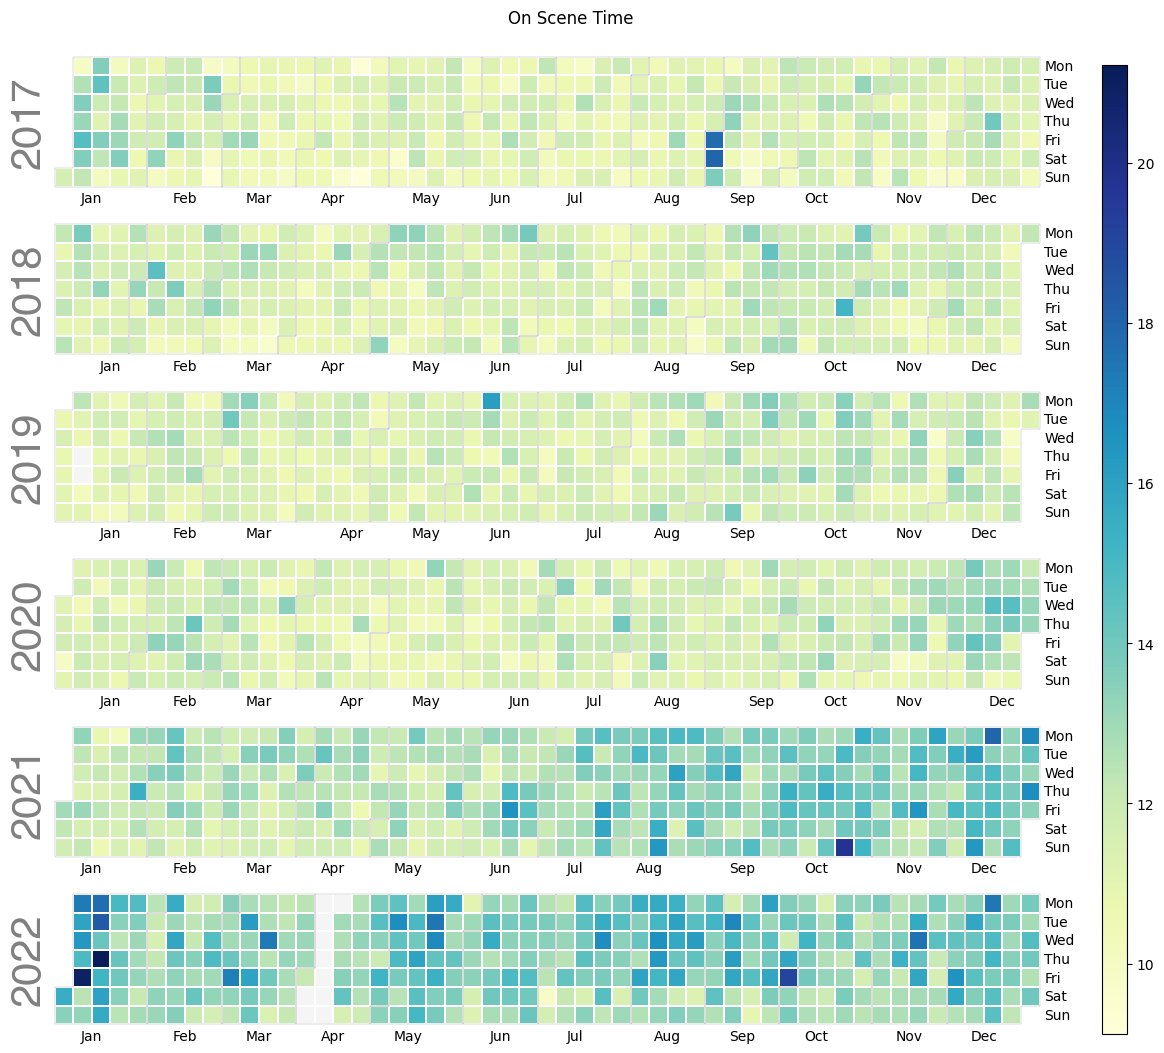

In [12]:
# Cal plot of the average response time by call type over the years and months
p = make_cal_plot(
    dat=dat,
    filter_call_types=["Medical Incident"],
    filter_years=range(2017, 2023),
    column_name="on_scene_time",
)
p.show()

/var/folders/2v/76qdb2rd0xzbgt6wjw2vgg2h0000gn/T/ipykernel_35984/987262989.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


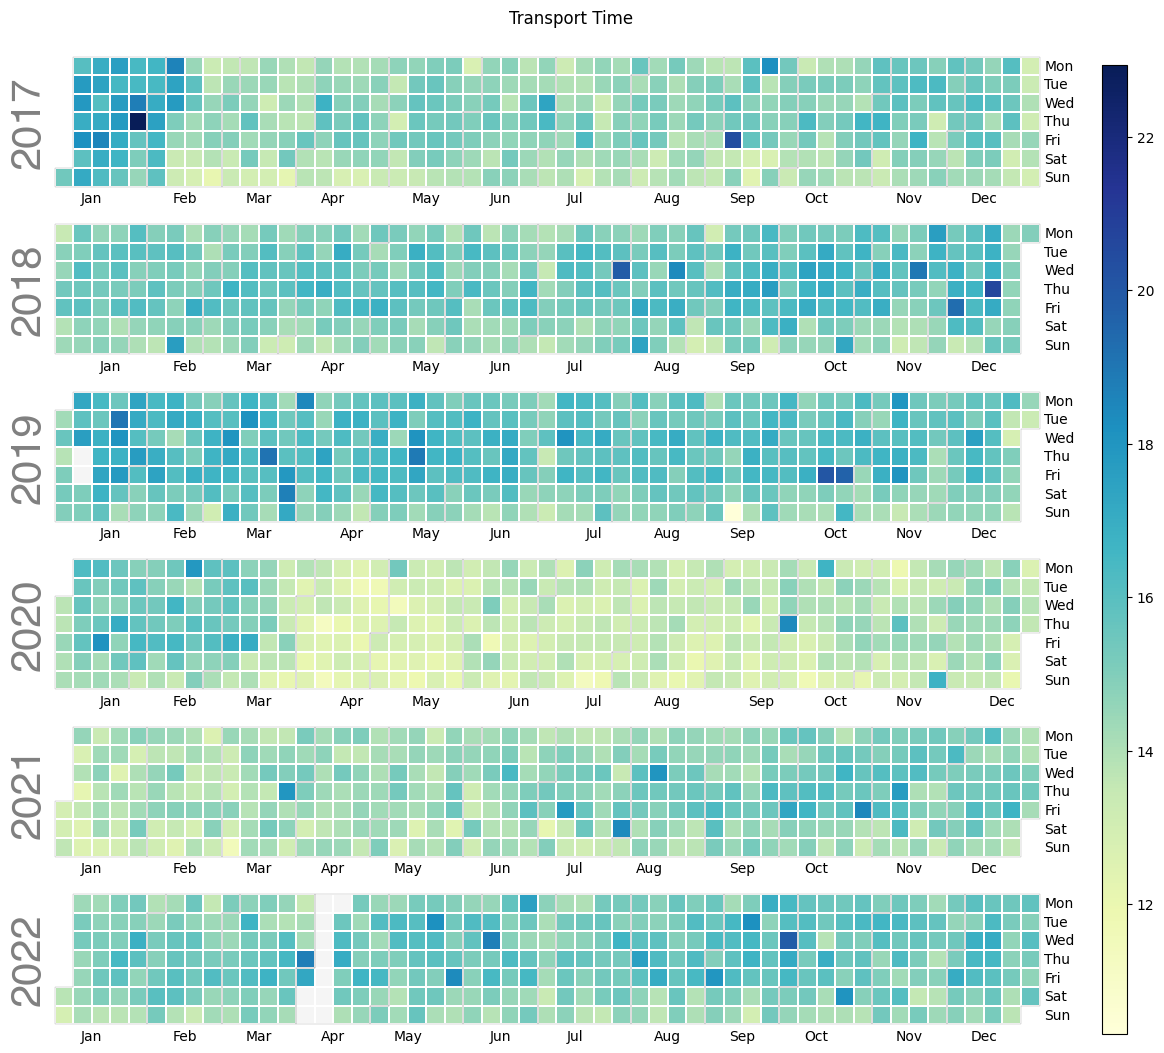

In [13]:
# Cal plot of the average transport time by call type over the years and months
p = make_cal_plot(
    dat=dat,
    filter_call_types=["Medical Incident"],
    filter_years=range(2017, 2023),
    column_name="transport_time",
)
p.show()

## 3. **Data Analysis**
- Describe your data analysis and explain what you've learned about the dataset.
- If relevant, talk about your machine-learning.

## 4. **Genre**. 
Which genre of data story did you use?
- Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
- Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?


## 5. **Visualizations**.
- Explain the visualizations you've chosen.
- Why are they right for the story you want to tell?

## 6. **Discussion**. 
Think critically about your creation
- What went well?,
- What is still missing? What could be improved?, Why?


## 7. **Contributions**. 
Who did what?
- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
- It is not OK simply to write "All group members contributed equally".

## 8. **References**
Make sure that you use references when they're needed and follow academic standards.